In [1]:
from pdf2image import convert_from_path
import pytesseract
import cv2
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import re

pdfs = "sample.pdf"
pdfs.encode('unicode_escape')
pages = convert_from_path(pdfs, 360)  # dpi is take to be 360 as it preserves the scan quality

i = 1

for page in pages: #converts list of page images into singular images 
    image_name = "Page_" + str(i) + ".jpg"  
    page.save(image_name, "JPEG")
    i = i+1 

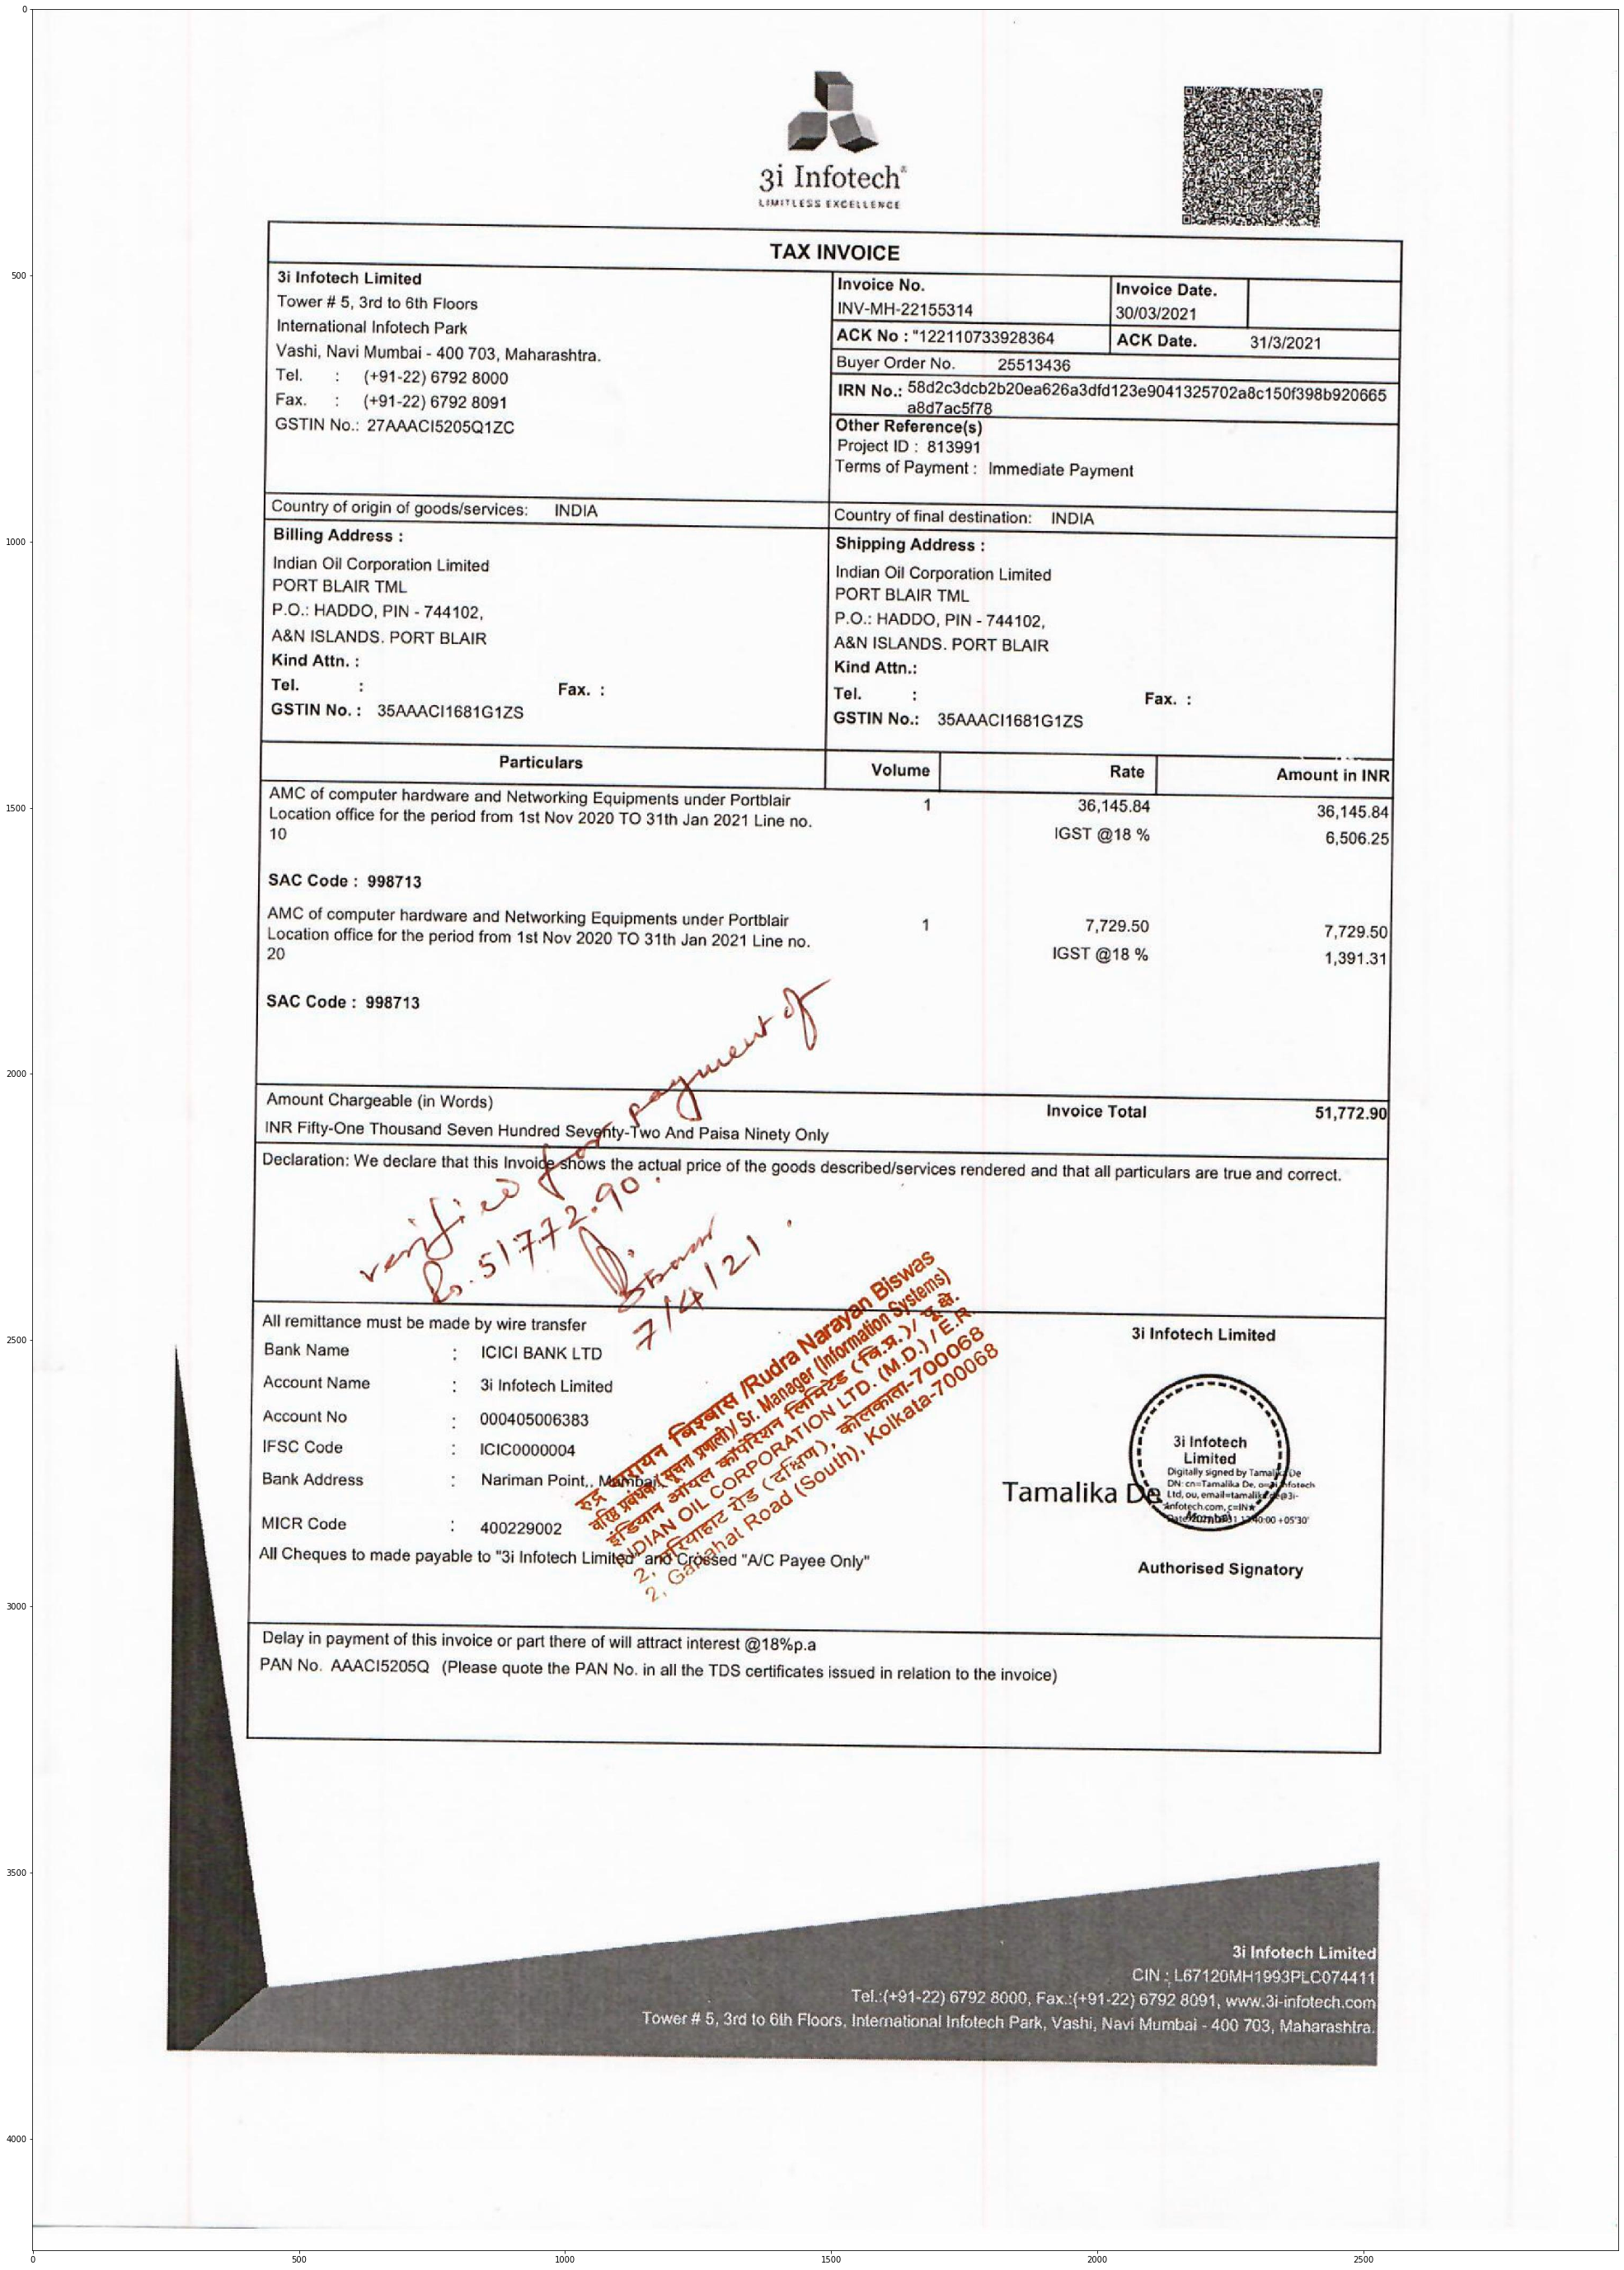

In [2]:
plt.figure(figsize=(50,50))
image = cv2.imread('Page_1.jpg')
plt.imshow(image )

In [3]:
# Functions to calculate skew angle of an image
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    #ato = cv2.GaussianBlur(gray, (1, 1), 0)
    #ret, thresh = cv2.threshold(ato, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]  # for angle of the largest text box
    print(angle)
    if angle > 85:
        return -1.0*(angle-90)
        
    if angle < -30 or angle> 30:
        angle = 0.0
    return -1.0 * angle

# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    if (angle==0.0):
        return cvImage
    return rotateImage(cvImage, -1.0 * angle)

In [4]:
def threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blur = cv2.GaussianBlur(gray, (1, 1), 0)  # in practice values of 1,1 gives the best OCR results
    
    thresh = cv2.threshold(blur , 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    return(thresh)

In [5]:
def read(final):
    
    custom_config = r'--oem 1 --psm 6' #using lstm with page segmentation mode as a single uniform block of text.
    
    dict=pytesseract.image_to_data(final, config=custom_config, output_type=pytesseract.Output.DICT)
    
    return dict

0.815728485584259
89.96784973144531
89.03146362304688
0.36910387873649597


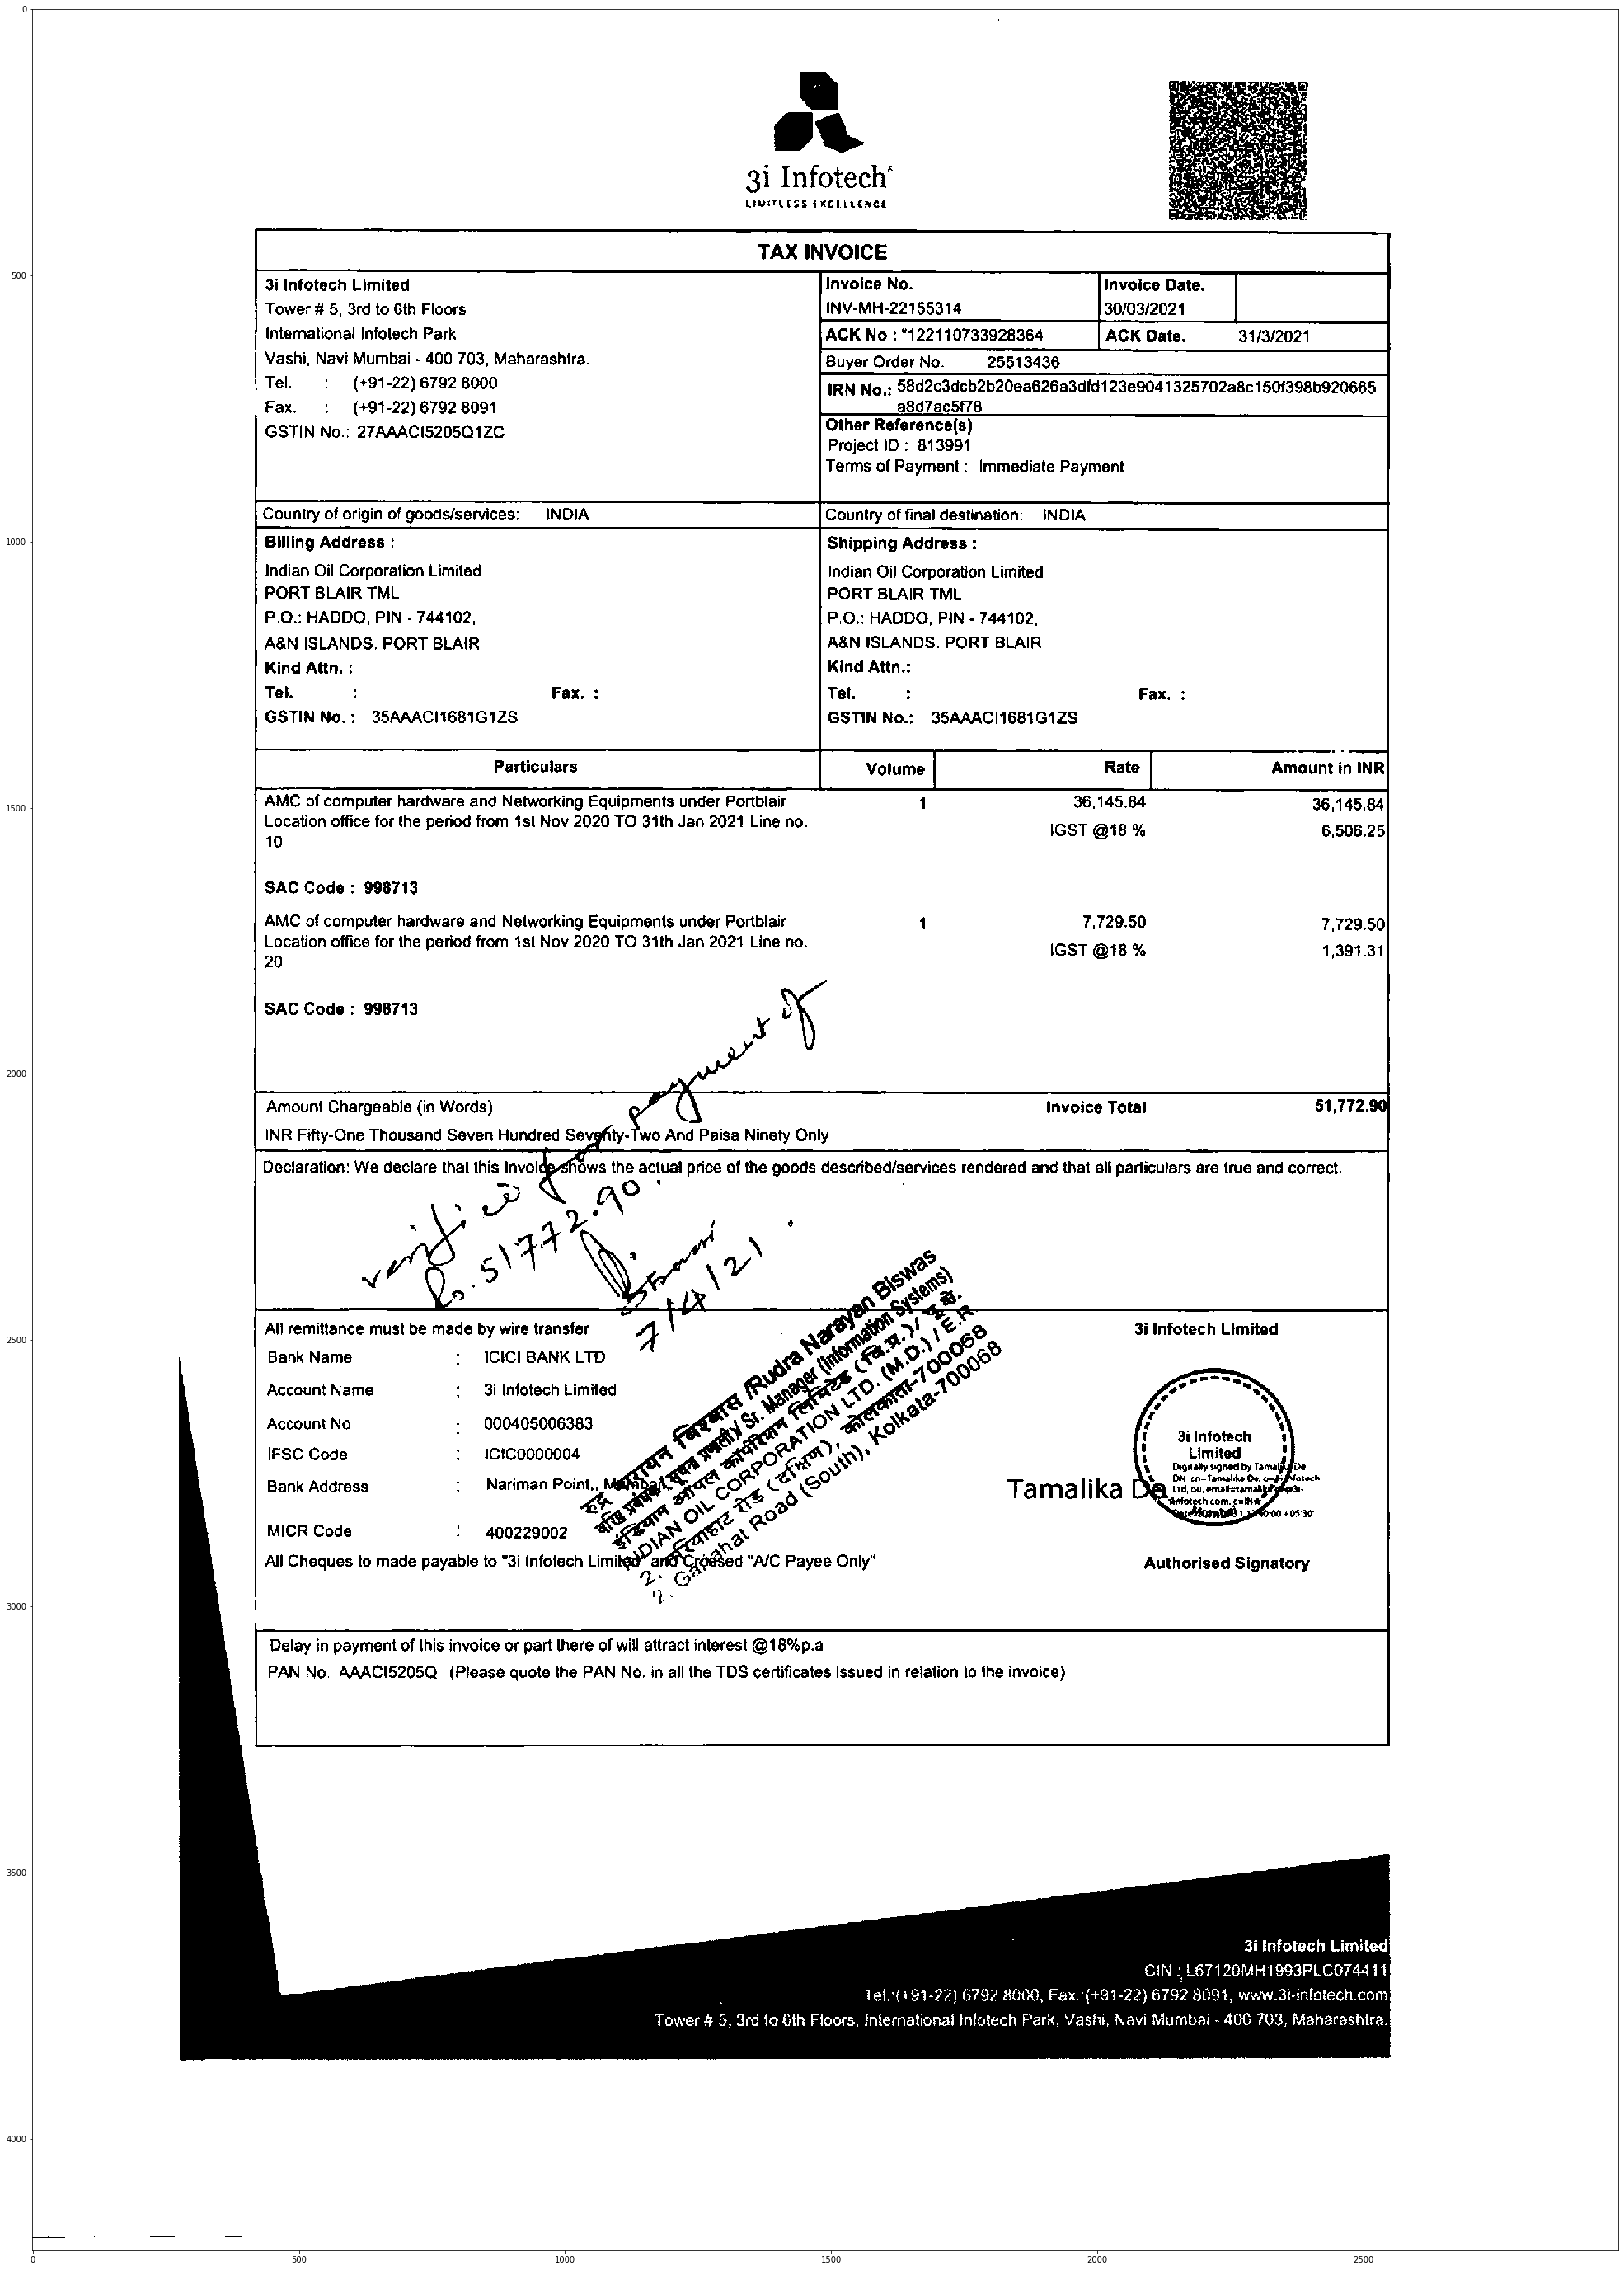

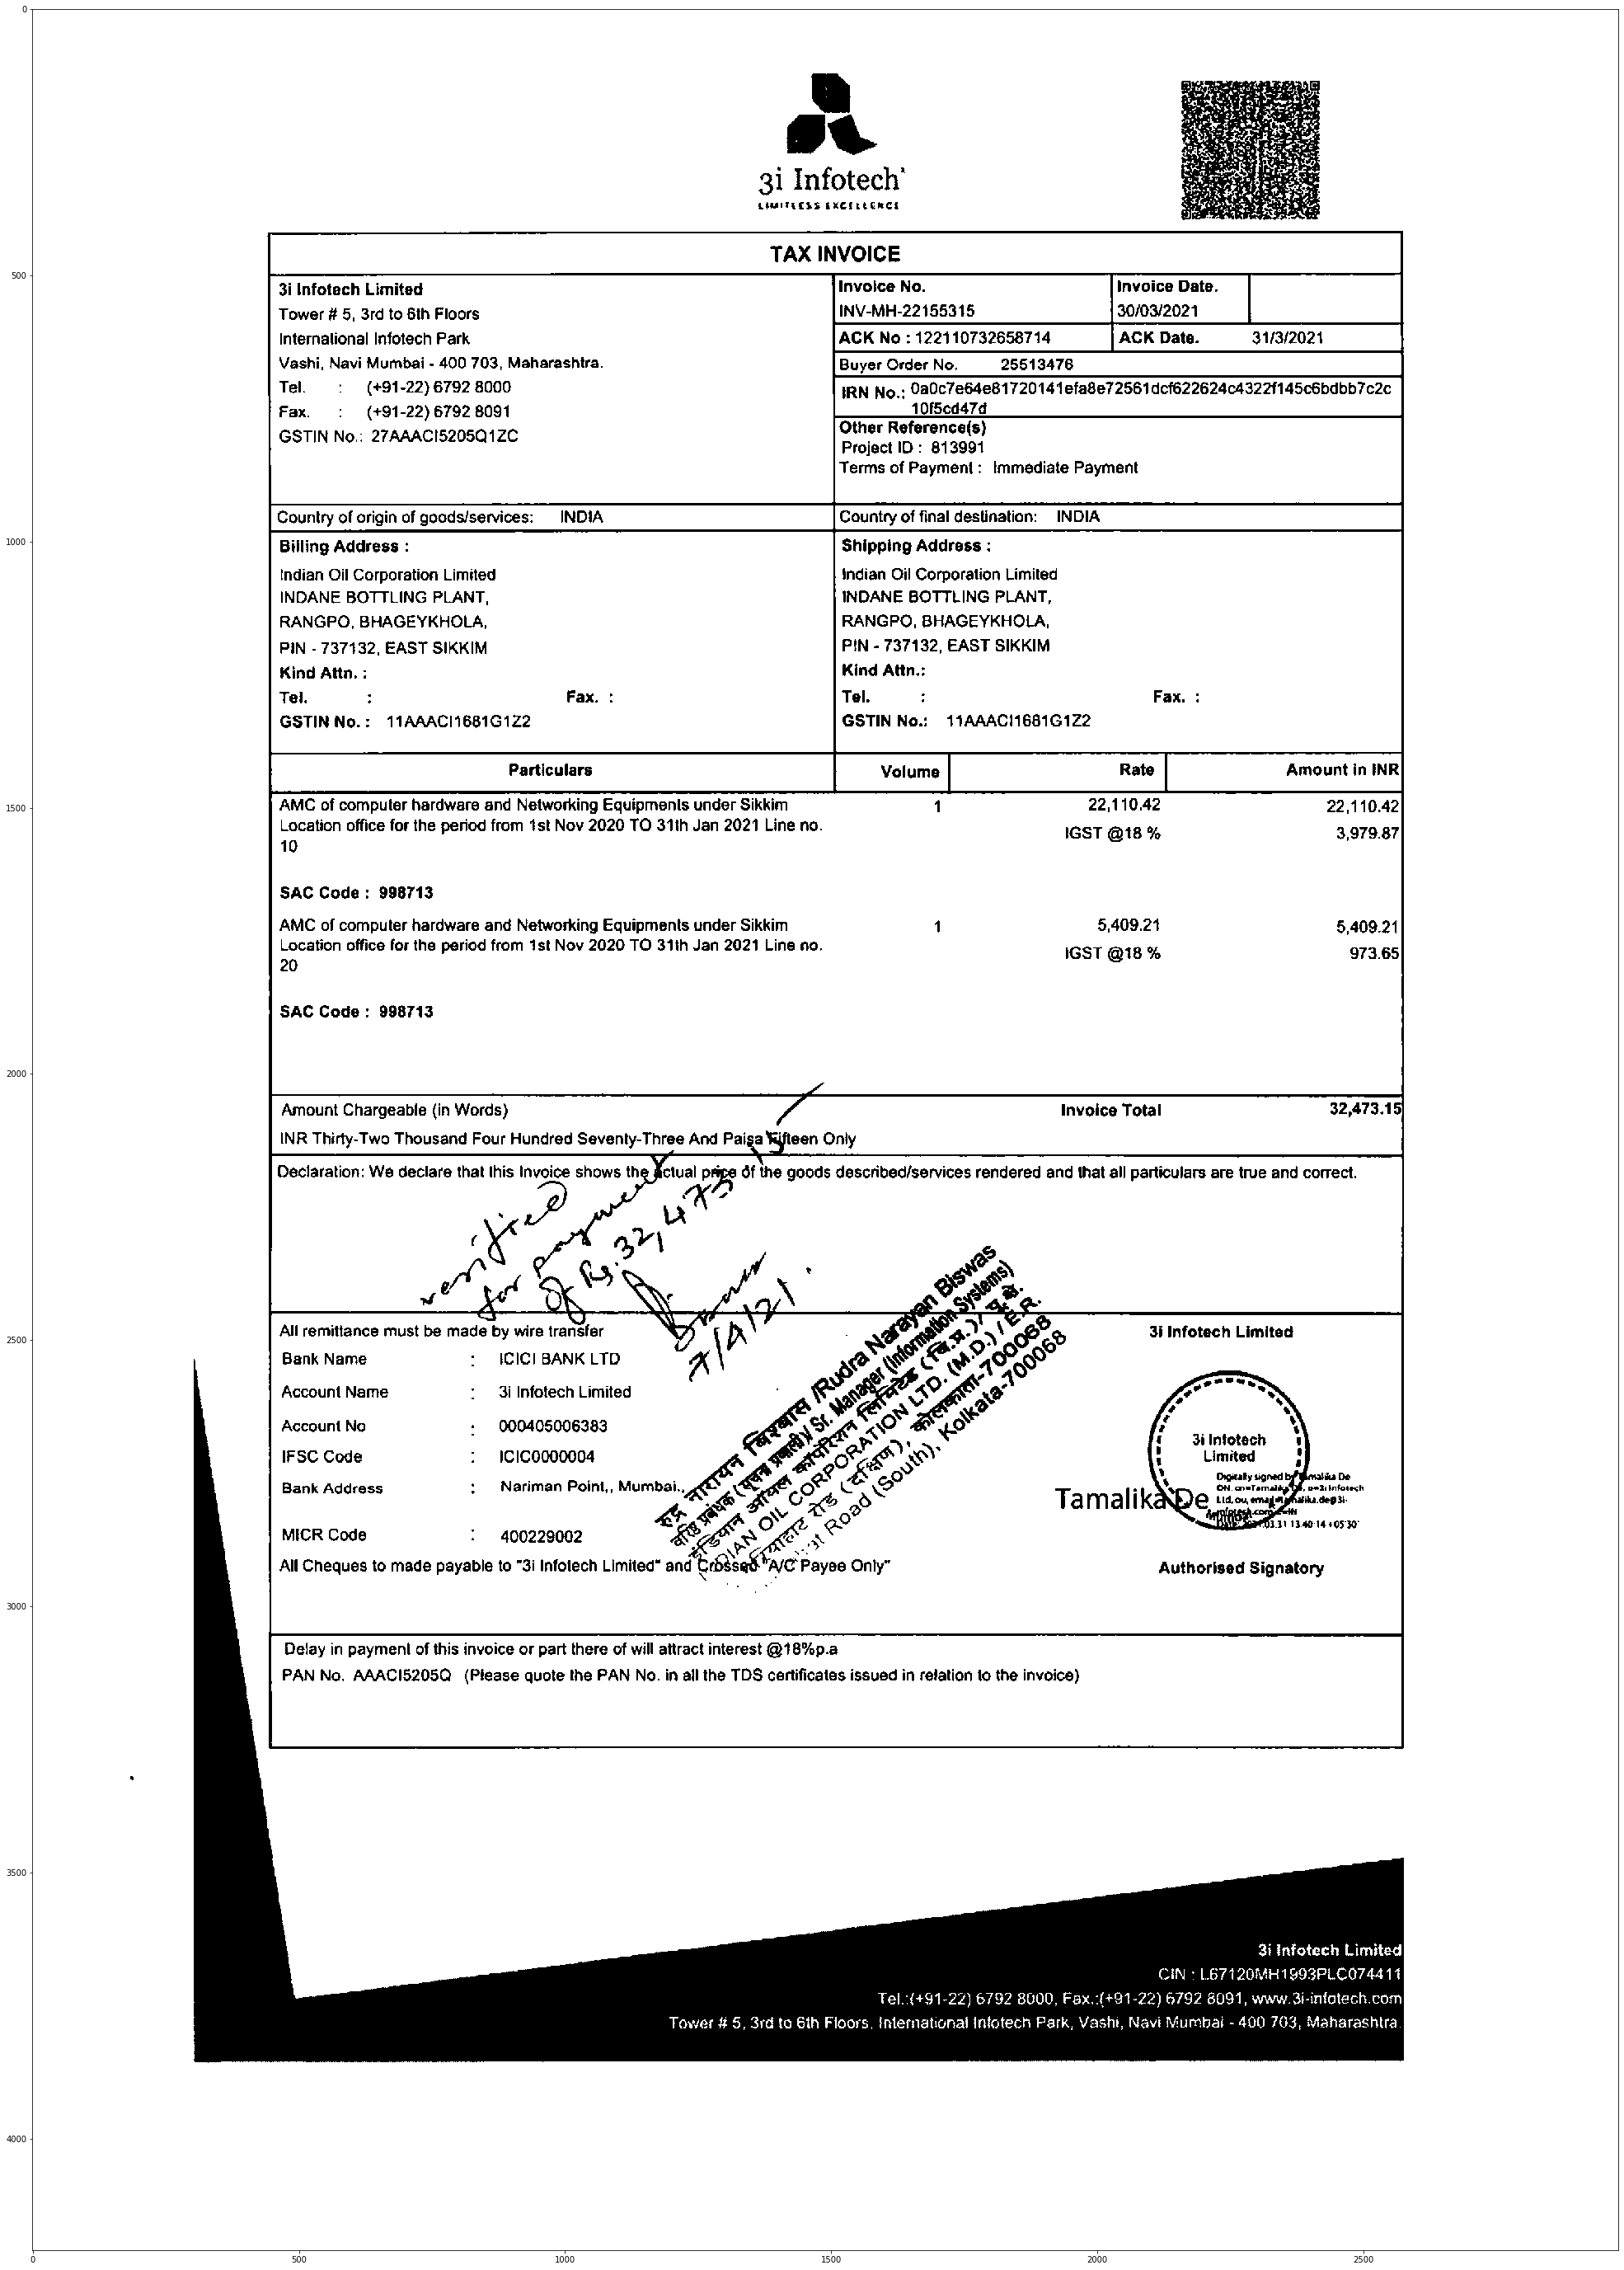

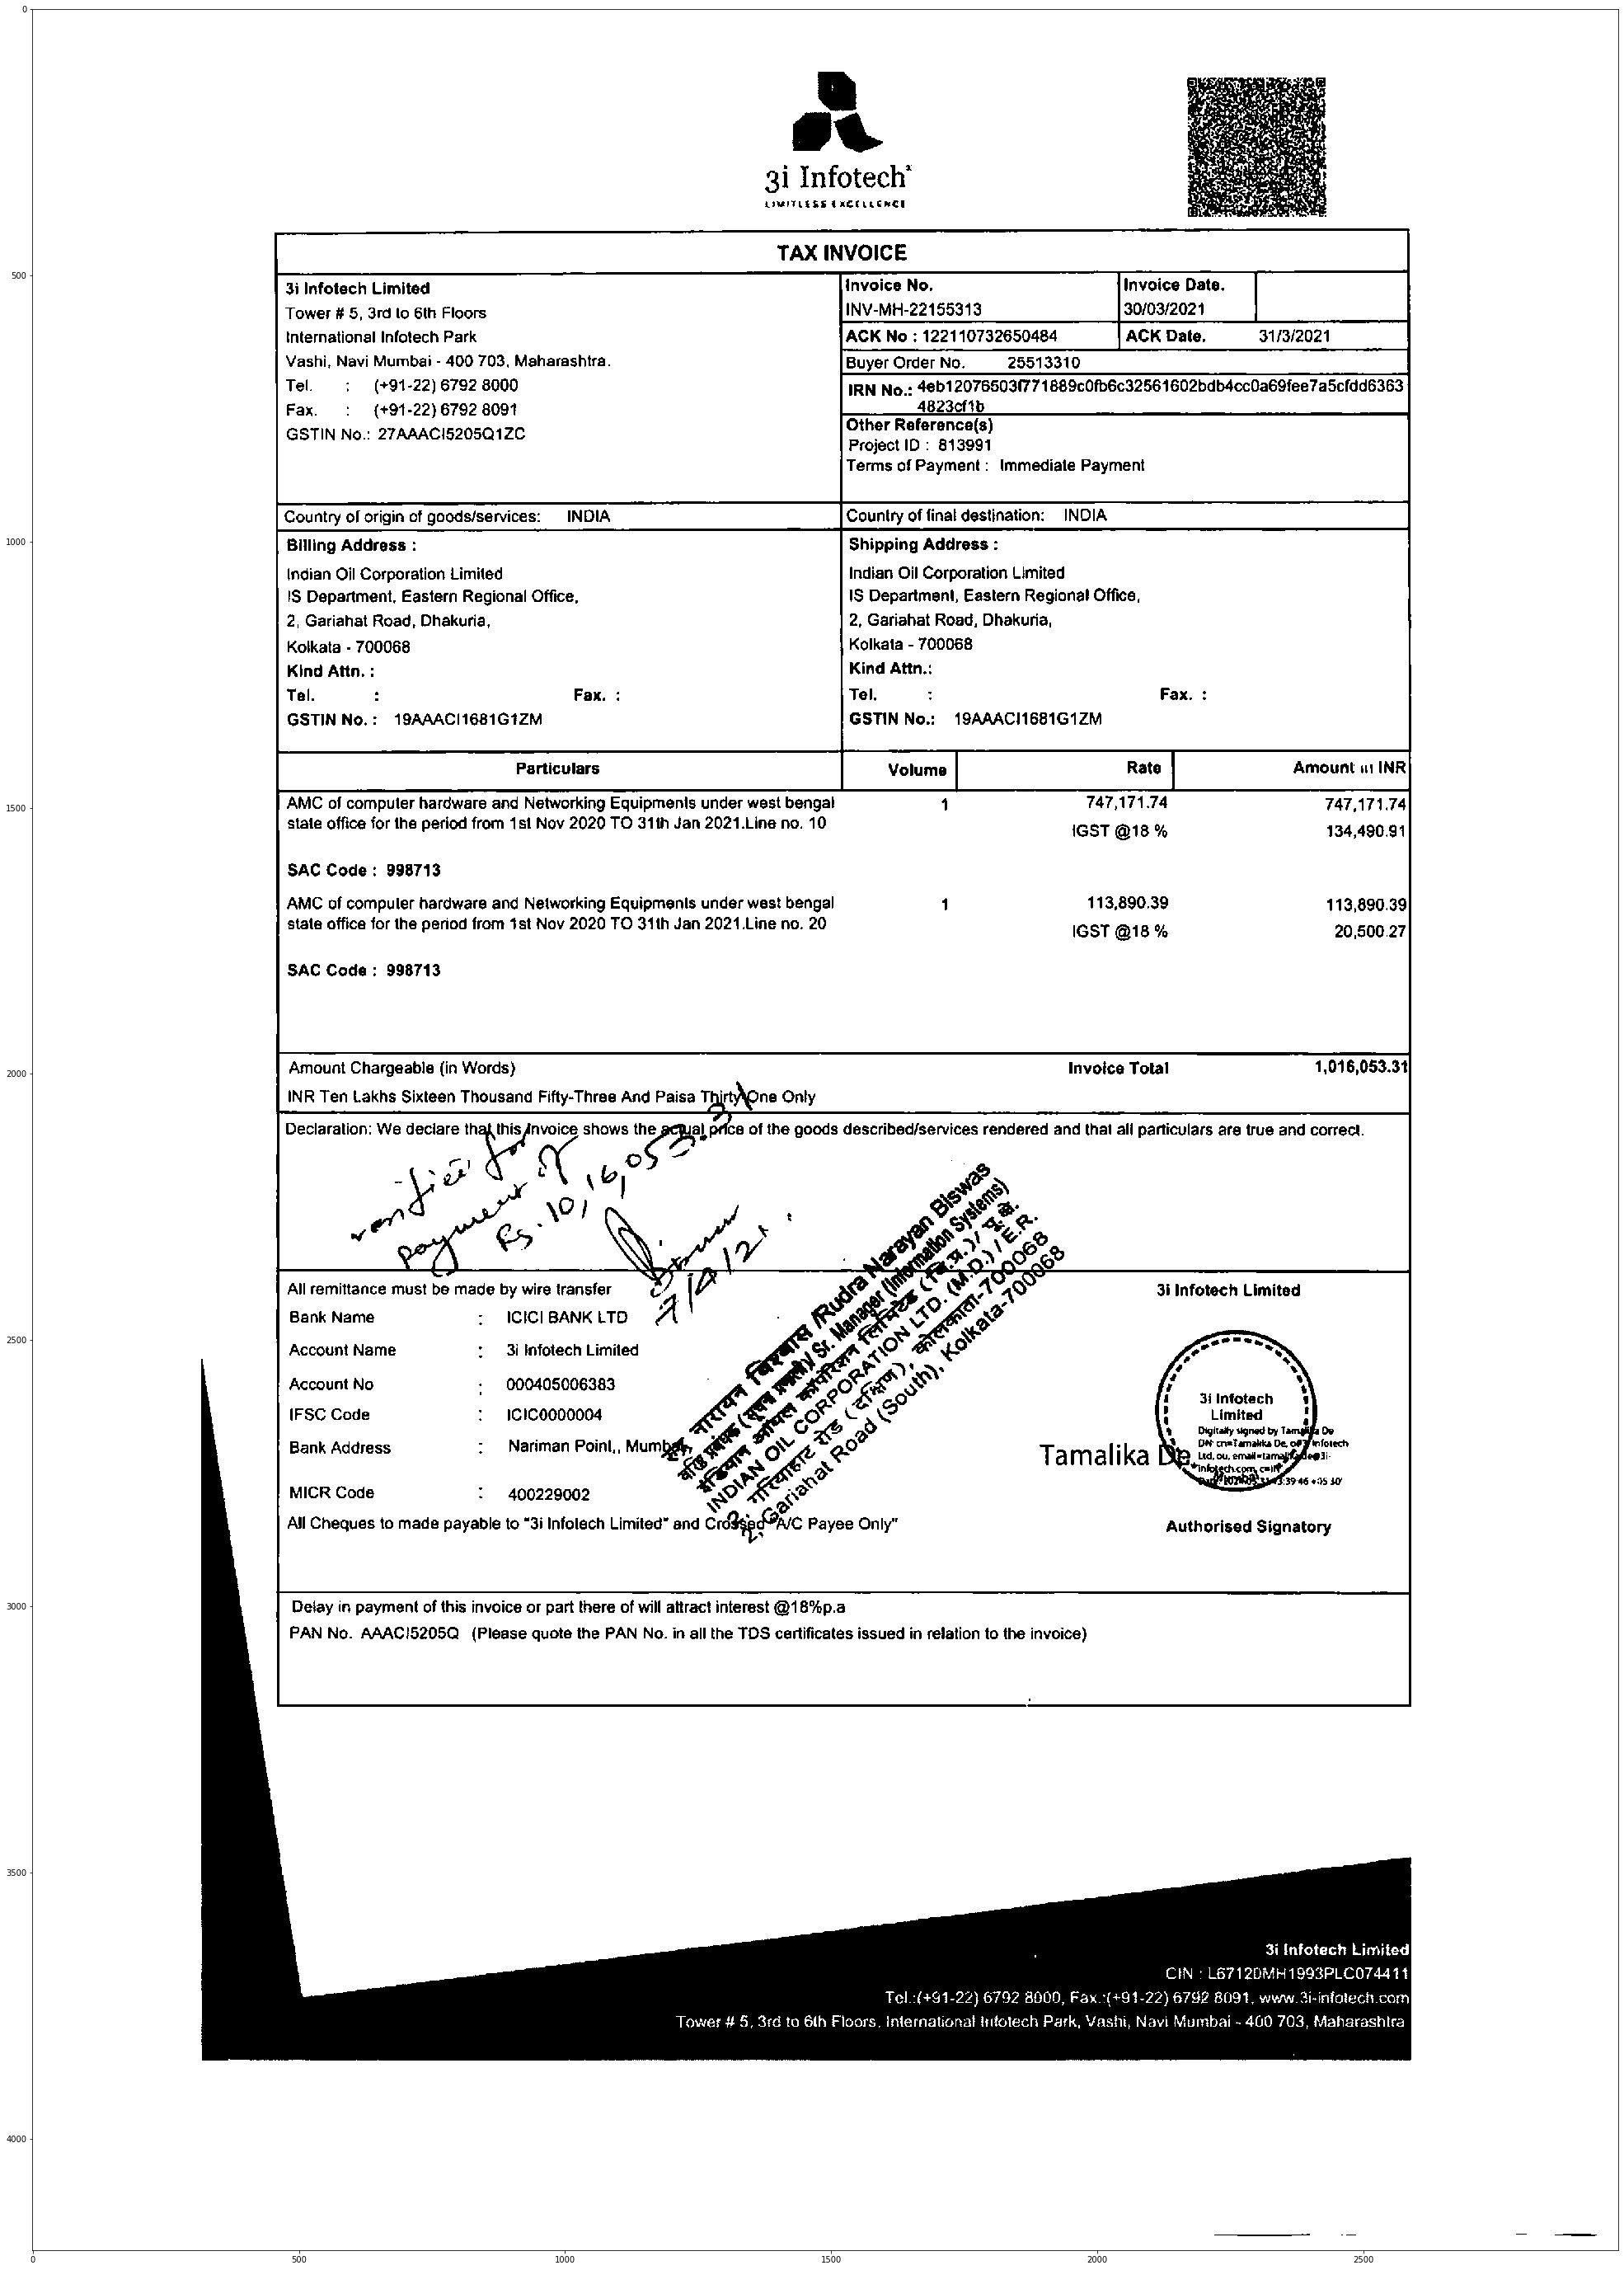

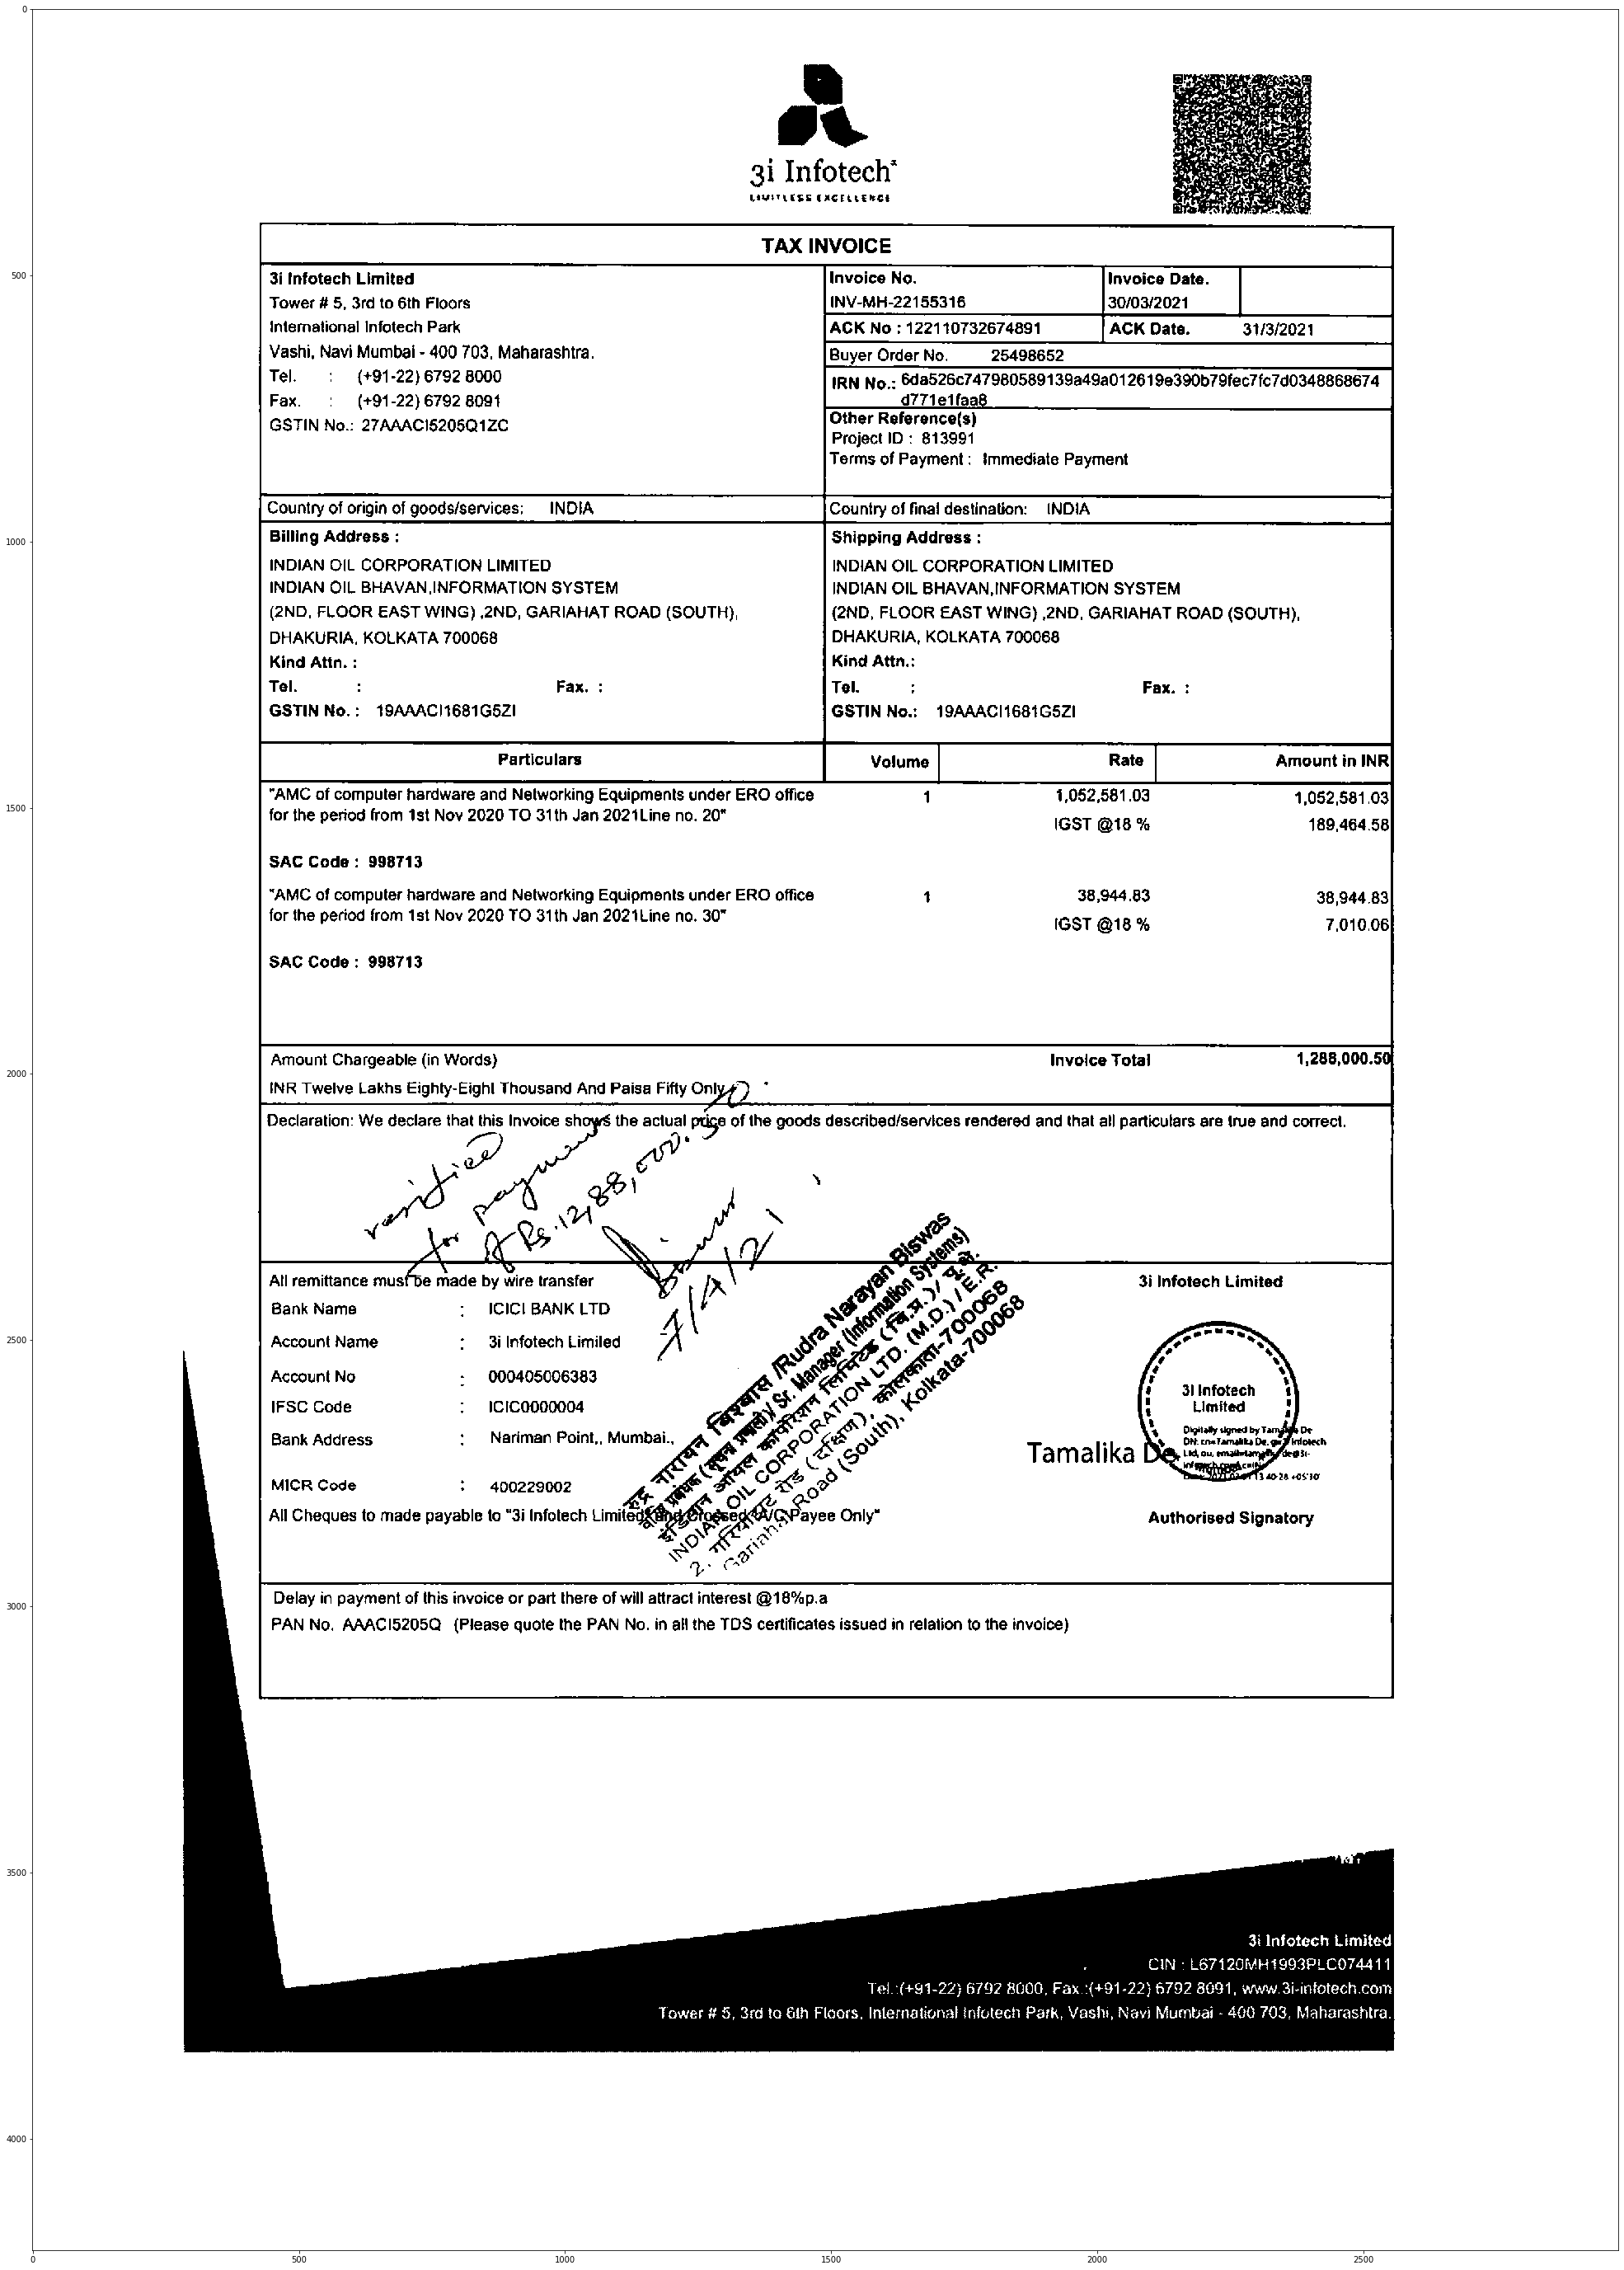

In [6]:
i=1
dict={}
for page in pages:    
    image = cv2.imread('Page_'+str(i)+'.jpg') #path 
    i=i+1
    deskewed=deskew(image)     # deskewed
    #            done by merging all printed letters keeping vertical distances intact and merging distance 
    #            adjacent words same, and then forming a minimum area reactangle 
    #            reference https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
    #            note: it was observed that only +/-2 deg is required at the most as it is a scanned document
    #                  and angle was sometimes close to 90 deg, indicating it found the vertical orientation, probably in
    #                  in case of text boxes being vertical, but by subtracting it by 90 optimal angle was obtained
    
    
    thresh=threshold(deskewed) # thresholded using a Gaussian weighted method and then OTSU thresholding
    #            references 
    #            https://docs.opencv.org/3.1.0/d7/d4d/tutorial_py_thresholding.html and
    #            https://www.digitalbangkokrecorder.com/blog/2017/03/programmatically-cleaning-document-scans-part-2/
    plt.figure(figsize=(50,50))
    plt.imshow(thresh, cmap='gray') #display for notebook
      
    dict[i-1]=read(thresh)

In [7]:
def findNextAndBelow(x,y,w,h,text):
    length=len(text)
    
    p = re.compile('.+([0-9])+.')
    
    invoice=['invoice','bill','inv']
    no=['no.','no','number','n0']
    
    total1=['invoice','total ','total','inv','grand']
    total2=['(inr)','total', 'amt:', 'amt', 'amount', 'charges ', 'charges']
    
    flagInv=0
    flagInv2=0
    distInv=[None]*4
    flagTot=0
    distTot=[None]*4
    
    for i in range(0,length):
        
        if(flagInv==0 and flagInv2==1 and (text[i].lower() in no) and x[i]>distInv[0]+distInv[2] and x[i]<distInv[0]+distInv[2]+50):
            print('found inv no')
            flagInv=1
            
        if( (text[i].lower() in invoice) and flagInv==0):
            distInv=(x[i],y[i],w[i],h[i])
            flagInv2=1
        
        if(flagTot==0 and (text[i].lower() in total2) and x[i]>distTot[0]+distTot[2] and x[i]<distTot[0]+distTot[2]+50):
            print('found total')
            flagTot=1
            
            
        if( (text[i].lower() in total1) and flagTot==0):
            distTot=(x[i],y[i],w[i],h[i])
        
        if(flagInv==1 and bool(p.match(text[i]) and (
                               (x[i]-distInv[0]>200 and y[i]-distInv[1]<15) 
                                or
                               (x[i]>distInv[0]-15 and x[i]<distInv[0]+15 and y[i]-distInv[1]<50 )))):
           print(text[i])
        if(flagTot==1 and bool(p.match(text[i]) and (
                               (x[i]-distTot[0]>200 and y[i]>distTot[1]-15 and y[i]<distTot[1]+15) 
                                or
                               (x[i]>distTot[0]-15 and x[i]<distTot[0]+15 and y[i]-distTot[1]<50 )))):
           print(text[i])
        
        # program finds matches in text, stores the distance computes if the adjacent text is one to be found, 
        # then tries to find a numerical text vertically or horizontally 
        # please note, this code is buggy and requires better implementation

In [8]:
somecounter = 1
for iterate in pages:           # iteration is done through data of the whole of the data this code 
    results=dict[somecounter]   # this code is mostly used for testing and printing r
    min_conf=-10
    length=len(results["text"])
    x=[] 
    y=[] 
    w=[] 
    h=[] 
    text=[]
    for i in range(0, len(results["text"])):
        if results["text"][i] is None:
            continue
        conf = int(results["conf"][i])
        
        if conf > min_conf:
            x.append(int(results["left"][i]))
            y.append(int(results["top"][i]))
            w.append(int(results["width"][i]))
            h.append(int(results["height"][i]))
    
            text.append(results["text"][i])
    
            #print("Text: {}".format(results["text"][i]))
            #print('x=',x[-1],'y=',y[-1],'w=',w[-1],'h=',h[-1])
    
    findNextAndBelow(x,y,w,h,text)
    somecounter=somecounter+1
    
print(max(x))

found inv no
INV-MH-22155314
found total
51,772.90
found inv no
INV-MH-22155315
found total
32,473.1
found inv no
INV-MH-22155313
found total
1,016,053.31
found inv no
INV-MH-22155316
found total
1,288,000.50
2447
